# Case study 1: Phân loại chữ số viết tay (MNIST)
Mục tiêu: thiết kế nhanh 2 mô hình CNN (có Keras và không dùng Keras high-level) để phân loại chữ số viết tay từ bộ MNIST và 100 ảnh tự tạo (nếu có). Notebook này ưu tiên ngắn gọn, dễ chạy, thời gian train ngắn nhưng vẫn có dropout/regularization để ổn định.


In [1]:
# Cấu hình chung
import os
import pathlib
import random
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Đặt seed để kết quả ổn định hơn
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

DATA_DIR = pathlib.Path('data')
TRAIN_CSV = DATA_DIR / 'mnist_train.csv'
TEST_CSV = DATA_DIR / 'mnist_test.csv'
CUSTOM_DIR = DATA_DIR / 'custom'

IMG_SHAPE = (28, 28, 1)
NUM_CLASSES = 10
BATCH_SIZE = 128
EPOCHS = 10  # tăng lên nếu GPU/CPU mạnh hơn, hoặc giảm để chạy nhanh

print(tf.__version__)
print('GPU available:', tf.config.list_physical_devices('GPU'))


2.20.0
GPU available: []


In [2]:
def load_mnist_csv(path: pathlib.Path, limit: int | None = None) -> Tuple[np.ndarray, np.ndarray]:
    """Đọc file CSV MNIST (cột 0 = label, còn lại = pixel)."""
    df = pd.read_csv(path)
    if limit:
        df = df.sample(n=limit, random_state=SEED)
    labels = df.iloc[:, 0].to_numpy(dtype=np.int64)
    images = df.iloc[:, 1:].to_numpy(dtype=np.float32).reshape(-1, 28, 28, 1) / 255.0
    return images, labels


def load_custom_images(folder: pathlib.Path) -> Tuple[np.ndarray, np.ndarray]:
    """Đọc ảnh người dùng tạo. Đặt tên file chứa nhãn, ví dụ '3_custom.png'."""
    if not folder.exists():
        return np.empty((0, *IMG_SHAPE), dtype=np.float32), np.empty((0,), dtype=np.int64)

    imgs, labels = [], []
    for file in folder.glob('*'):
        if not file.suffix.lower() in {'.png', '.jpg', '.jpeg', '.bmp'}:
            continue
        label_digits = [c for c in file.stem if c.isdigit()]
        if not label_digits:
            continue  # bỏ qua file không xác định nhãn
        label = int(label_digits[0])
        img = tf.io.read_file(str(file))
        img = tf.io.decode_image(img, channels=1, expand_animations=False)
        img = tf.image.resize(img, IMG_SHAPE[:2])
        img = tf.cast(img, tf.float32) / 255.0
        imgs.append(img.numpy())
        labels.append(label)
    if not imgs:
        return np.empty((0, *IMG_SHAPE), dtype=np.float32), np.empty((0,), dtype=np.int64)
    return np.stack(imgs), np.array(labels, dtype=np.int64)


# Tải data
X_train_full, y_train_full = load_mnist_csv(TRAIN_CSV)
X_test, y_test = load_mnist_csv(TEST_CSV)
X_custom, y_custom = load_custom_images(CUSTOM_DIR)

print('MNIST train:', X_train_full.shape, 'test:', X_test.shape)
print('Custom images:', X_custom.shape)

# Gộp thêm 100 ảnh tự tạo (nếu có)
if len(X_custom) > 0:
    X_train_full = np.concatenate([X_train_full, X_custom], axis=0)
    y_train_full = np.concatenate([y_train_full, y_custom], axis=0)
    print('Train sau khi gộp custom:', X_train_full.shape)

# Chia train/val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=SEED, stratify=y_train_full
)

print('Train:', X_train.shape, 'Val:', X_val.shape)


MNIST train: (60000, 28, 28, 1) test: (10000, 28, 28, 1)
Custom images: (120, 28, 28, 1)
Train sau khi gộp custom: (60120, 28, 28, 1)
Train: (54108, 28, 28, 1) Val: (6012, 28, 28, 1)


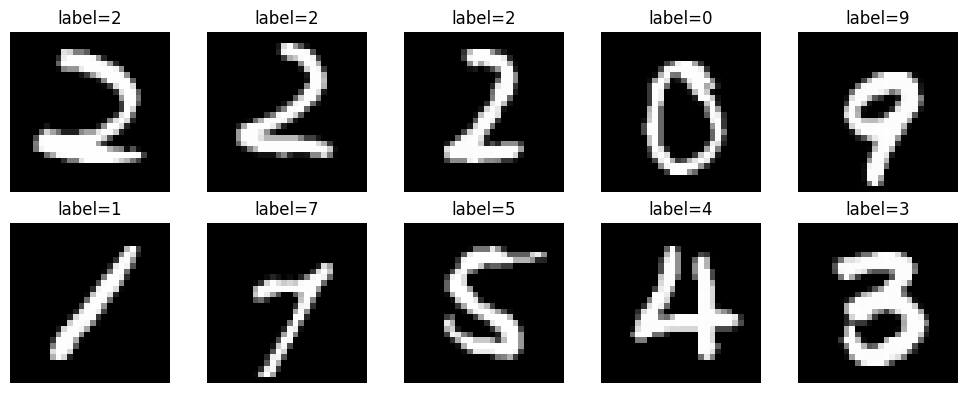

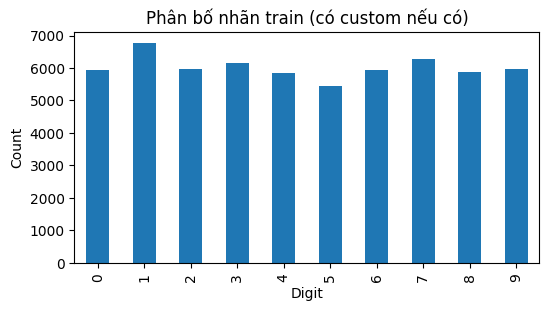

In [3]:
# Hiển thị vài ảnh và phân bố nhãn
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for ax, idx in zip(axes.flatten(), range(10)):
    ax.imshow(X_train[idx].squeeze(), cmap='gray')
    ax.set_title(f'label={y_train[idx]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Phân bố nhãn sau khi gộp
pd.Series(y_train_full).value_counts().sort_index().plot(kind='bar', figsize=(6,3))
plt.title('Phân bố nhãn train (có custom nếu có)')
plt.xlabel('Digit')
plt.ylabel('Count')
plt.show()


In [4]:
# Tạo tf.data pipeline cho nhanh
train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(buffer_size=len(X_train), seed=SEED)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)



In [15]:
def build_keras_cnn() -> tf.keras.Model:
    inputs = tf.keras.Input(shape=IMG_SHAPE)
    x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
    )
    return model

keras_model = build_keras_cnn()
keras_model.summary()

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True, monitor='val_accuracy')
]

history_keras = keras_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=2,
)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,625,866 (6.20 MB)

 Trainable params: 1,625,866 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
423/423 - 32s - 76ms/step - accuracy: 0.9222 - loss: 0.2698 - val_accuracy: 0.9775 - val_loss: 0.0991
Epoch 2/10
423/423 - 34s - 80ms/step - accuracy: 0.9716 - loss: 0.1113 - val_accuracy: 0.9840 - val_loss: 0.0776
Epoch 3/10
423/423 - 32s - 76ms/step - accuracy: 0.9790 - loss: 0.0877 - val_accuracy: 0.9859 - val_loss: 0.0705
Epoch 4/10
423/423 - 34s - 80ms/step - accuracy: 0.9824 - loss: 0.0753 - val_accuracy: 0.9850 - val_loss: 0.0706
Epoch 5/10
423/423 - 33s - 78ms/step - accuracy: 0.9848 - loss: 0.0634 - val_accuracy: 0.9864 - val_loss: 0.0692
Epoch 6/10
423/423 - 35s - 82ms/step - accuracy: 0.9862 - loss: 0.0586 - val_accuracy: 0.9865 - val_loss: 0.0649
Epoch 7/10
423/423 - 34s - 80ms/step - accuracy: 0.9880 - loss: 0.0510 - val_accuracy: 0.9875 - val_loss: 0.0653
Epoch 8/10
423/423 - 35s - 82ms/step - accuracy: 0.9891 - loss: 0.0468 - val_accuracy: 0.9872 - val_loss: 0.0671
Epoch 9/10
423/423 - 34s - 81ms/step - accuracy: 0.9900 - loss: 0.0433 - val_accuracy: 0.9879 - 

In [16]:
# Đánh giá Keras model
keras_test_loss, keras_test_acc = keras_model.evaluate(test_ds, verbose=0)
print(f'Keras test accuracy: {keras_test_acc:.4f}, loss: {keras_test_loss:.4f}')

# Classification report
y_pred_probs = keras_model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
print(classification_report(y_test, y_pred, digits=4))


Keras test accuracy: 0.9911, loss: 0.0304
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
              precision    recall  f1-score   support

           0     0.9899    0.9969    0.9934       980
           1     0.9921    0.9974    0.9947      1135
           2     0.9884    0.9922    0.9903      1032
           3     0.9911    0.9960    0.9936      1010
           4     0.9849    0.9959    0.9904       982
           5     0.9932    0.9877    0.9904       892
           6     0.9947    0.9885    0.9916       958
           7     0.9902    0.9874    0.9888      1028
           8     0.9938    0.9877    0.9907       974
           9     0.9930    0.9802    0.9865      1009

    accuracy                         0.9911     10000
   macro avg     0.9911    0.9910    0.9911     10000
weighted avg     0.9911    0.9911    0.9911     10000



In [17]:
class LowLevelCNN(tf.Module):
    def __init__(self):
        super().__init__()
        glorot = tf.initializers.GlorotUniform(seed=SEED)
        self.w1 = tf.Variable(glorot(shape=(3, 3, 1, 32)), name='w1')
        self.b1 = tf.Variable(tf.zeros([32]), name='b1')
        self.w2 = tf.Variable(glorot(shape=(3, 3, 32, 64)), name='w2')
        self.b2 = tf.Variable(tf.zeros([64]), name='b2')
        self.w3 = tf.Variable(glorot(shape=(14 * 14 * 64, 128)), name='w3')
        self.b3 = tf.Variable(tf.zeros([128]), name='b3')
        self.w4 = tf.Variable(glorot(shape=(128, NUM_CLASSES)), name='w4')
        self.b4 = tf.Variable(tf.zeros([NUM_CLASSES]), name='b4')

    @property
    def trainable_variables(self):
        return [self.w1, self.b1, self.w2, self.b2, self.w3, self.b3, self.w4, self.b4]

    def __call__(self, x, training: bool = False):
        x = tf.nn.conv2d(x, self.w1, strides=1, padding='SAME') + self.b1
        x = tf.nn.relu(x)
        x = tf.nn.conv2d(x, self.w2, strides=1, padding='SAME') + self.b2
        x = tf.nn.relu(x)
        x = tf.nn.max_pool2d(x, ksize=2, strides=2, padding='SAME')
        if training:
            x = tf.nn.dropout(x, rate=0.25, seed=SEED)
        x = tf.reshape(x, [tf.shape(x)[0], -1])
        x = tf.nn.relu(tf.matmul(x, self.w3) + self.b3)
        if training:
            x = tf.nn.dropout(x, rate=0.5, seed=SEED)
        logits = tf.matmul(x, self.w4) + self.b4
        return logits


low_model = LowLevelCNN()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

train_loss_results, train_acc_results = [], []
val_acc_results = []

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = low_model(x, training=True)
        loss_value = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits))
    grads = tape.gradient(loss_value, low_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, low_model.trainable_variables))
    preds = tf.argmax(logits, axis=1, output_type=tf.int32)
    acc = tf.reduce_mean(tf.cast(tf.equal(preds, tf.cast(y, tf.int32)), tf.float32))
    return loss_value, acc

@tf.function
def val_step(x, y):
    logits = low_model(x, training=False)
    preds = tf.argmax(logits, axis=1, output_type=tf.int32)
    acc = tf.reduce_mean(tf.cast(tf.equal(preds, tf.cast(y, tf.int32)), tf.float32))
    return acc

for epoch in range(EPOCHS):
    epoch_losses, epoch_accs = [], []
    for batch_x, batch_y in train_ds:
        loss_value, acc = train_step(batch_x, batch_y)
        epoch_losses.append(loss_value)
        epoch_accs.append(acc)
    train_loss_results.append(tf.reduce_mean(epoch_losses).numpy())
    train_acc_results.append(tf.reduce_mean(epoch_accs).numpy())

    # đơn giản: chỉ tính val acc
    val_acc_epoch = []
    for batch_x, batch_y in val_ds:
        val_acc_epoch.append(val_step(batch_x, batch_y))
    val_acc_results.append(tf.reduce_mean(val_acc_epoch).numpy())

    print(f"Epoch {epoch+1}/{EPOCHS} - loss={train_loss_results[-1]:.4f} - acc={train_acc_results[-1]:.4f} - val_acc={val_acc_results[-1]:.4f}")


Epoch 1/10 - loss=0.2595 - acc=0.9246 - val_acc=0.9790
Epoch 2/10 - loss=0.1042 - acc=0.9739 - val_acc=0.9827
Epoch 3/10 - loss=0.0820 - acc=0.9801 - val_acc=0.9859
Epoch 4/10 - loss=0.0725 - acc=0.9836 - val_acc=0.9859
Epoch 5/10 - loss=0.0650 - acc=0.9845 - val_acc=0.9857
Epoch 6/10 - loss=0.0580 - acc=0.9861 - val_acc=0.9879
Epoch 7/10 - loss=0.0510 - acc=0.9881 - val_acc=0.9872
Epoch 8/10 - loss=0.0464 - acc=0.9891 - val_acc=0.9867
Epoch 9/10 - loss=0.0422 - acc=0.9898 - val_acc=0.9879
Epoch 10/10 - loss=0.0376 - acc=0.9910 - val_acc=0.9882


In [18]:
# Đánh giá model low-level (không Keras high-level)
def predict_low(ds):
    preds = []
    for batch_x, _ in ds:
        logits = low_model(batch_x, training=False)
        preds.append(tf.argmax(logits, axis=1))
    return tf.concat(preds, axis=0).numpy()

low_preds = predict_low(test_ds)
low_acc = np.mean(low_preds == y_test)
print(f'Low-level CNN test accuracy: {low_acc:.4f}')
print(classification_report(y_test, low_preds, digits=4))


Low-level CNN test accuracy: 0.9898
              precision    recall  f1-score   support

           0     0.9908    0.9939    0.9924       980
           1     0.9965    0.9947    0.9956      1135
           2     0.9847    0.9952    0.9899      1032
           3     0.9843    0.9960    0.9902      1010
           4     0.9969    0.9786    0.9877       982
           5     0.9910    0.9899    0.9905       892
           6     0.9895    0.9864    0.9880       958
           7     0.9902    0.9854    0.9878      1028
           8     0.9847    0.9938    0.9893       974
           9     0.9890    0.9832    0.9861      1009

    accuracy                         0.9898     10000
   macro avg     0.9898    0.9897    0.9897     10000
weighted avg     0.9898    0.9898    0.9898     10000



In [19]:
# So sánh nhanh
print({'keras_acc': float(keras_test_acc), 'low_level_acc': float(low_acc)})

print('\nGhi chú tối ưu hóa:')
print('- Tăng EPOCHS lên 5-8 nếu có GPU để đạt ~99%+.')
print('- Data custom: đặt file ảnh 28x28 vào data/custom, tên chứa nhãn (vd 7_me.png).')
print('- Có thể thêm BatchNorm hoặc Augmentation (shift/rotate nhỏ) để cải thiện tổng quát.')


{'keras_acc': 0.991100013256073, 'low_level_acc': 0.9898}

Ghi chú tối ưu hóa:
- Tăng EPOCHS lên 5-8 nếu có GPU để đạt ~99%+.
- Data custom: đặt file ảnh 28x28 vào data/custom, tên chứa nhãn (vd 7_me.png).
- Có thể thêm BatchNorm hoặc Augmentation (shift/rotate nhỏ) để cải thiện tổng quát.


In [20]:
# Lưu model để deploy
EXPORT_DIR = pathlib.Path('artifacts')
EXPORT_DIR.mkdir(exist_ok=True)

# 1) Keras model (.keras – định dạng native Keras 3)
keras_export = EXPORT_DIR / 'keras_cnn.keras'
keras_model.save(keras_export)
print('Đã lưu Keras model tại:', keras_export)

# 2) Low-level CNN dưới dạng SavedModel (phục vụ tf/TF Serving)
class LowLevelExport(tf.Module):
    def __init__(self, model: LowLevelCNN):
        super().__init__()
        # gắn model vào attribute để TF tracking biến
        self.model = model

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, 28, 28, 1], dtype=tf.float32)])
    def __call__(self, x):
        logits = self.model(x, training=False)
        return {
            'logits': logits,
            'probs': tf.nn.softmax(logits)
        }

low_export = LowLevelExport(low_model)
low_export_dir = EXPORT_DIR / 'lowlevel_cnn'
tf.saved_model.save(low_export, low_export_dir)
print('Đã lưu low-level SavedModel tại:', low_export_dir)


Đã lưu Keras model tại: artifacts\keras_cnn.keras
INFO:tensorflow:Assets written to: artifacts\lowlevel_cnn\assets


INFO:tensorflow:Assets written to: artifacts\lowlevel_cnn\assets


Đã lưu low-level SavedModel tại: artifacts\lowlevel_cnn


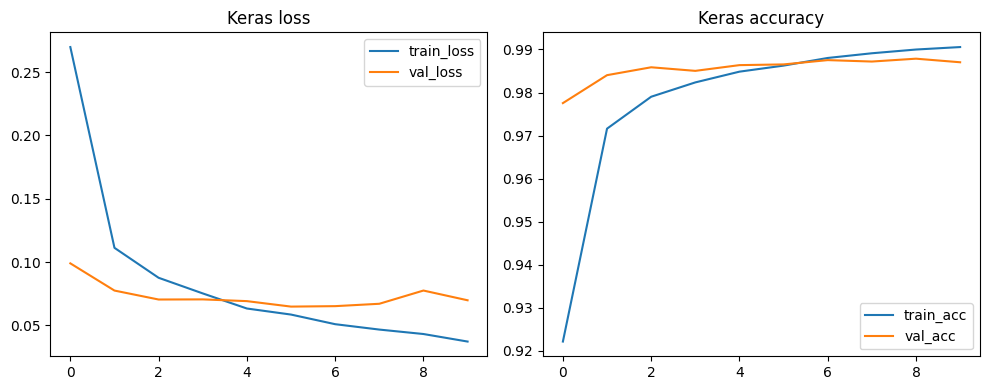

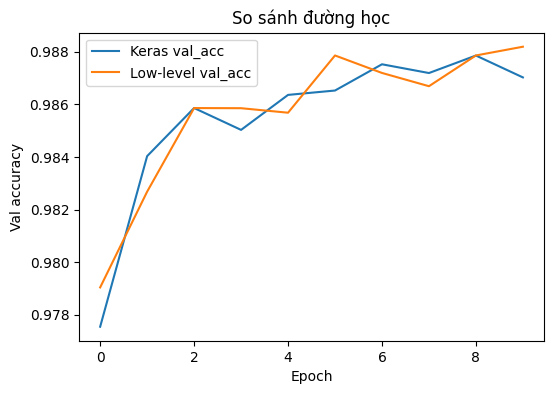

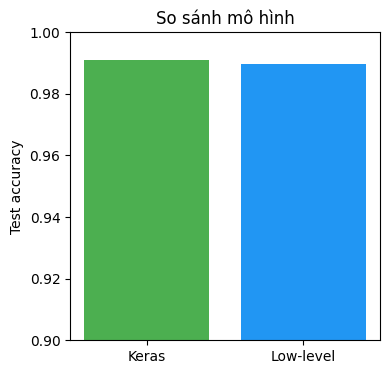

In [21]:
# Biểu đồ so sánh
# 1) Đường học Keras
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(history_keras.history['loss'], label='train_loss')
axes[0].plot(history_keras.history['val_loss'], label='val_loss')
axes[0].set_title('Keras loss')
axes[0].legend()

axes[1].plot(history_keras.history['accuracy'], label='train_acc')
axes[1].plot(history_keras.history['val_accuracy'], label='val_acc')
axes[1].set_title('Keras accuracy')
axes[1].legend()
plt.tight_layout()
plt.show()

# 2) Đường học Low-level vs Keras (val accuracy)
plt.figure(figsize=(6,4))
plt.plot(history_keras.history['val_accuracy'], label='Keras val_acc')
plt.plot(val_acc_results, label='Low-level val_acc')
plt.xlabel('Epoch')
plt.ylabel('Val accuracy')
plt.title('So sánh đường học')
plt.legend()
plt.show()

# 3) Bar chart so sánh độ chính xác test của 2 mô hình
plt.figure(figsize=(4,4))
plt.bar(['Keras', 'Low-level'], [keras_test_acc, low_acc], color=['#4caf50', '#2196f3'])
plt.ylim(0.9, 1.0)
plt.ylabel('Test accuracy')
plt.title('So sánh mô hình')
plt.show()
